In [1]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
        self.classifier = self._create_classifier(latent_dim)
#         self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_pred = self.classify(z, training=training)
#         y_pred = self.decode(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
#             Dropout(0.5),
            Dense(units=latent_dim)
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * n_filters[0]),  # factor 4 due to conv.
            Reshape((io_shape[0]//4, io_shape[1]//4, n_filters[0])),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Reshape((4,4,1)),
            Conv2D(filters=10, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'),
            Flatten(),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(10, activation='softmax')
        ])

1: 1-split, latent dims 16

In [10]:
import keras
import numpy as np

n_splits = 1
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

# model = MultiSplit(n_splits, latent_dim, io_shape)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')
y_test = keras.utils.to_categorical(y_test)
print(x_test_split.shape)

(10000, 1, 28, 28, 1)


1-split

Epoch 1/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3469 - acc: 0.8989 - val_loss: 0.1544 - val_acc: 0.9541
Epoch 2/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1455 - acc: 0.9568 - val_loss: 0.1378 - val_acc: 0.9599
Epoch 3/40
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1278 - acc: 0.9615 - val_loss: 0.1242 - val_acc: 0.9635
Epoch 4/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1155 - acc: 0.9653 - val_loss: 0.1118 - val_acc: 0.9673
Epoch 5/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1065 - acc: 0.9682 - val_loss: 0.1047 - val_acc: 0.9694
Epoch 6/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1011 - acc: 0.9699 - val_loss: 0.1037 - val_acc: 0.9708
Epoch 7/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0963 - acc: 0.9711 - val_loss: 0.0968 - val_acc: 0.9714
Epoch 8/40
1875/1875 [==============================] - 3s 1ms

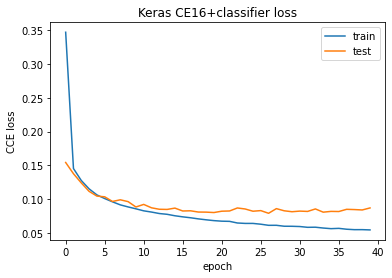

In [4]:
model.encoder.load_weights('../weights/19_CE16_epoch25.h5')
# # model.encoder.load_weights('../weights/18_CE4_ordered_epoch25.h5')
for layer in model.encoder.layers:
    layer.trainable = False
    
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam') # COMPILE AFTER WEIGHTS LOADED
# model.compile(loss='mse', optimizer='adam') # COMPILE AFTER WEIGHTS LOADED

# history = model.fit(x_train_split, x_train, validation_data=(x_test_split, x_test), epochs=25, batch_size=32)
history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=25, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Keras CE16+classifier loss')
plt.ylabel('CCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [5]:
import keras
import numpy as np

n_splits = 4
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

fourSplit = MultiSplit(n_splits, latent_dim, io_shape)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')
y_test = keras.utils.to_categorical(y_test)
print(x_test_split.shape)

(10000, 4, 14, 14, 1)


Epoch 1/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4483 - acc: 0.8681 - val_loss: 0.2374 - val_acc: 0.9273
Epoch 2/40
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2231 - acc: 0.9312 - val_loss: 0.1969 - val_acc: 0.9428
Epoch 3/40
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1952 - acc: 0.9401 - val_loss: 0.2019 - val_acc: 0.9381
Epoch 4/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1813 - acc: 0.9444 - val_loss: 0.1738 - val_acc: 0.9490
Epoch 5/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1707 - acc: 0.9475 - val_loss: 0.1620 - val_acc: 0.9532
Epoch 6/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1632 - acc: 0.9497 - val_loss: 0.1605 - val_acc: 0.9532
Epoch 7/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1566 - acc: 0.9516 - val_loss: 0.1525 - val_acc: 0.9551
Epoch 8/40
1875/1875 [==============================] - 3s 2ms

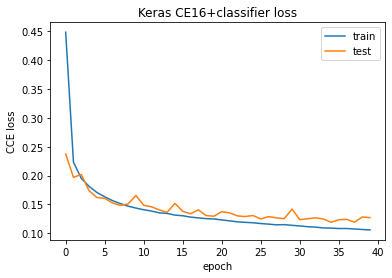

In [6]:
fourSplit.encoder.load_weights('../weights/18_CE4_ordered_epoch25.h5')
for layer in fourSplit.encoder.layers:
    layer.trainable = False
    
fourSplit.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam') # COMPILE AFTER WEIGHTS LOADED
# fourSplit.compile(loss='mse', optimizer='adam') # COMPILE AFTER WEIGHTS LOADED

# history = fourSplit.fit(x_train_split, x_train, validation_data=(x_test_split, x_test), epochs=25, batch_size=32)
history = fourSplit.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=25, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Keras CE16+classifier loss')
plt.ylabel('CCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# model.encoder.save_weights('../weights/19_CE4+dropout_epoch25.h5')

(40000, 4) (10000, 4, 14, 14, 1)
8 tf.Tensor(0.9818454, shape=(), dtype=float32)


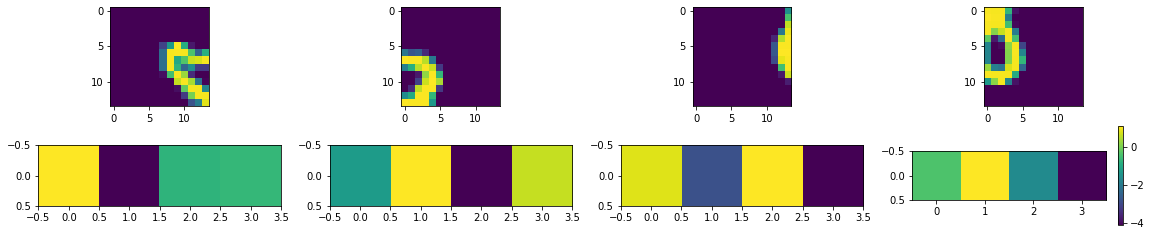

In [55]:
import random

z = fourSplit.encode(x_test_split)
y = fourSplit.classify(z)
# plt.imshow(z[0])
plt.figure(figsize=(20,4))
j = random.randint(0, 10000)
print(z.shape, x_test_split.shape)
print(np.argmax(y[j]), max(y[j]))
for i in range(4):
    ax = plt.subplot(2, 4, i+1)
    plt.imshow(x_test_split[j][i].reshape(14,14))
    ax = plt.subplot(2, 4, i+5)
    plt.imshow(tf.reshape(z[j*4+i],(1,4)))

plt.colorbar()


In [12]:
preds_1 = model.predict(x_test_split)
# preds_2 = fourSplit.predict(x_test_split)

In [13]:
true_preds1 = np.array([np.argmax(p) == np.argmax(y) for p, y in zip(preds_1, y_test)])
# true_preds2 = np.array([np.argmax(p) == np.argmax(y) for p, y in zip(preds_2, y_test)])
print((10000 - np.sum(true_preds1))/10000)  # 1-split
# print((10000 - np.sum(true_preds2))/10000)  # 4-split

0.0248


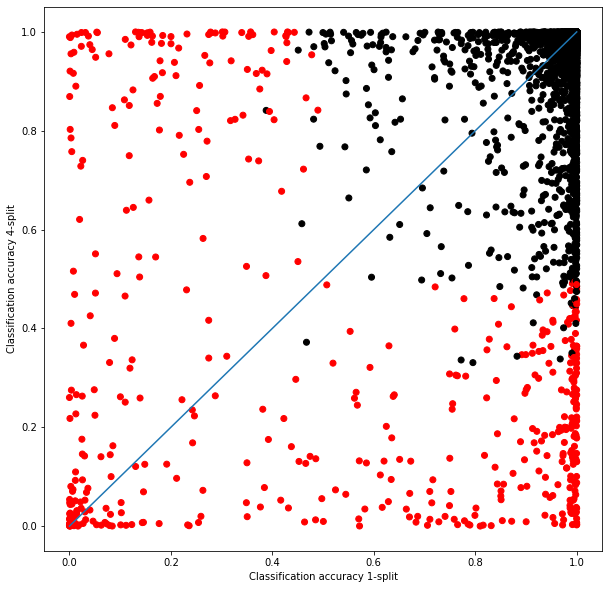

In [15]:
ps1 = [p[np.argmax(y)] for p, y in zip(preds_1, y_test)]
ps2 = [p[np.argmax(y)] for p, y in zip(preds_2, y_test)]
plt.figure(figsize=(10,10))

cols = ['black' if (np.argmax(p1) == np.argmax(y) and np.argmax(p2) ==np.argmax(y)) else 'red' for p1, p2, y in zip(preds_1, preds_2, y_test)]
# cols = ['black' if np.argmax(p2) == np.argmax(y) else 'red' for p1, p2, y in zip(preds_1, preds_2, y_test)]

plt.scatter(ps1, ps2, c=cols)
x = np.linspace(0,1,10)
plt.plot(x, x)
plt.xlabel('Classification accuracy 1-split')
plt.ylabel('Classification accuracy 4-split')
plt.savefig('../img/19_4split_vs_1split_acc.png')